In [5]:
#|include: false

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

import fastai
from fastai.data.all import *

import torch

from fastai.basics import *
from fastai.callback.all import *

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import RobustScaler

from torch.nn import functional as F
import pandas as pd

# Notes about Sequence Modelling

I lately participated in the [Google Brain - Ventilator Pressure Prediction](https://www.kaggle.com/c/ventilator-pressure-prediction) competition. I didn't score decent, but I still learned a lot. And some of it is worth to sum up, so I can easily look it up later.

The goal of the competition was to predict airway pressure of lungs that are ventilated in a clinician-intensive procedure. Given values of the input pressure (`u_in`) we had to predict the output `pressure` for a time frame of a few seconds.


In [6]:
#|include: false

BS = 64
WORKERS = 4
EPOCHS = 5 #100

In [7]:
#|include: false

in_path = Path('../input')
train = pd.read_csv(in_path/'train.csv')

<AxesSubplot:xlabel='time_step', ylabel='Pressure'>

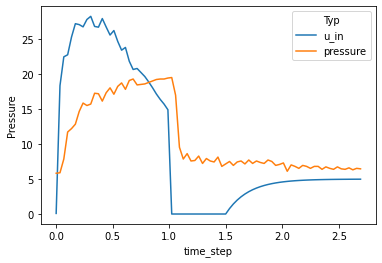

In [8]:
#|echo: false

sample = train[train.breath_id==1][['time_step', 'u_in', 'pressure']].melt(id_vars= 'time_step', var_name = 'Typ', value_name = 'Pressure')
sns.lineplot(x = 'time_step', y = 'Pressure', hue ='Typ', data=sample)

Since all `u_in` values for a time frame were given we can build a bidirectional sequence model. Unless in a typical time-series problem where the future points are unknown at a certain time step, we know the future and past input values. Therefore I decided not to *mask* the sequences while training.

A good model choice for sequencing tasks are LSTMs and Transformers. I built a model that combines both architectures. I also tried XGBoost with a lot of features (especially windowing, rolling, lead, lag features) engineering, But neural nets (NN) performed better, here. Though I kept some of the engineered features as embeddings for the NN model.

The competition metric was mean average error (MAE). Only those pressures were evaluated, that appear while filling the lungs with oxygen.


## Feature engineering

Besides the given features, *u_in*, *u_out*, *R*, *C* and *time_step* I defined several features. They can by categorized as:

- area (accumulation of u_in over time) from [this notebook](https://www.kaggle.com/cdeotte/ensemble-folds-with-median-0-153)
- one hot encoding of ventilator parameters R and C
- statistical (mean, max, skewness, quartiles, rolling mean, ...)
- shifted input pressure
- input pressure performance over window
- inverse features

To reduce memory consumption I used a function from [this notebook](https://www.kaggle.com/konradb/tabnet-end-to-end-starter).

In [1]:
def gen_features(df, norm=False):
    
    # area feature from https://www.kaggle.com/cdeotte/ensemble-folds-with-median-0-153
    df['area'] = df['time_step'] * df['u_in']
    df['area_crv'] = (1.5-df['time_step']) * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['area_crv'] = df.groupby('breath_id')['area_crv'].cumsum()
    df['area_inv'] = df.groupby('breath_id')['area'].transform('max') - df['area']
    
    df['ts'] = df.groupby('breath_id')['id'].rank().astype('int')
    
    df['R4'] = 1/df['R']**4
    df['R'] = df['R'].astype('str')
    df['C'] = df['C'].astype('str')
    
    df = pd.get_dummies(df)
    
    for in_out in [0,1]: #,1
        for qs in [0.2, 0.25, 0.5, 0.9, 0.95]:
            df.loc[:, f'u_in_{in_out}_q{str(qs*100)}'] = 0
            df.loc[df.u_out==in_out, f'u_in_{in_out}_q{str(qs*100)}'] = df[df.u_out==in_out].groupby('breath_id')['u_in'].transform('quantile', q=0.2)
    
        for agg_type in ['count', 'std', 'skew','mean', 'min', 'max', 'median', 'last', 'first']:
            df.loc[:,f'u_out_{in_out}_{agg_type}'] = 0
            df.loc[df.u_out==in_out, f'u_out_{in_out}_{agg_type}'] = df[df.u_out==in_out].groupby('breath_id')['u_in'].transform(agg_type)
    
        if norm:
            df.loc[:,f'u_in'] = (df.u_in - df[f'u_out_{in_out}_mean']) / (df[f'u_out_{in_out}_std']+1e-6)
    
    
    for s in range(1,8):
        df.loc[:,f'shift_u_in_{s}'] = 0
        df.loc[:,f'shift_u_in_{s}'] = df.groupby('breath_id')['u_in'].shift(s)
        df.loc[:,f'shift_u_in_m{s}'] = 0
        df.loc[:,f'shift_u_in_m{s}'] = df.groupby('breath_id')['u_in'].shift(-s)
    
    df.loc[:,'perf1'] = (df.u_in / df.shift_u_in_1).clip(-2,2)
    df.loc[:,'perf3'] = (df.u_in / df.shift_u_in_3).clip(-2,2)
    df.loc[:,'perf5'] = (df.u_in / df.shift_u_in_5).clip(-2,2)
    df.loc[:,'perf7'] = (df.u_in / df.shift_u_in_7).clip(-2,2)
    
    df.loc[:,'perf1'] = df.perf1-1
    df.loc[:,'perf3'] = df.perf3-1
    df.loc[:,'perf5'] = df.perf5-1
    df.loc[:,'perf7'] = df.perf7-1
    
    df.loc[:,'perf1inv'] = (df.u_in / df.shift_u_in_m1).clip(-2,2)
    df.loc[:,'perf3inv'] = (df.u_in / df.shift_u_in_m3).clip(-2,2)
    df.loc[:,'perf5inv'] = (df.u_in / df.shift_u_in_m5).clip(-2,2)
    df.loc[:,'perf7inv'] = (df.u_in / df.shift_u_in_m7).clip(-2,2)
    
    df.loc[:,'perf1inv'] = df.perf1inv-1
    df.loc[:,'perf3inv'] = df.perf3inv-1
    df.loc[:,'perf5inv'] = df.perf5inv-1
    df.loc[:,'perf7inv'] = df.perf7inv-1
    
    df.loc[:,'rol_mean5'] = df.u_in.rolling(5).mean()
    
    return df

In [10]:
#|include: false

# from https://www.kaggle.com/konradb/tabnet-end-to-end-starter

def reduce_memory_usage(df):
    
    start_memory = np.round(df.memory_usage().sum() / 1024**2,2)
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = np.round(df.memory_usage().sum() / 1024**2,2)
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by { np.round(100 * (start_memory - end_memory) / start_memory,2) } % ")
    return df

In [11]:
#|include: false

train = gen_features(train,False).fillna(0)
train = reduce_memory_usage(train)

Memory usage of dataframe is 2889.7 MB
Memory usage of dataframe after reduction 782.87 MB
Reduced by 72.91 % 


### Scaler
The data was transformed with *scikit's RobustScaler* to reduce influence of outliers.

In [12]:
features =  list(set(train.columns)-set(['id','breath_id','pressure','kfold_2021','kfold']))
features.sort()

rs = RobustScaler().fit(train[features]) 

## Folds
I didn't do cross validation here, but instead trained the final model on the entire dataset. Nevertheless it's helpful to build kfolds for model evaluation. I build GroupKFold over `breath_id` to keep the entire time frame in the same fold.

In [13]:
#|include: false

# Kfold
train['kfold'] = -1

n_splits = 5
#skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=2020)
skf = GroupKFold(n_splits = n_splits)

for fold, (trn, vld) in enumerate(skf.split(X = train, y = train['kfold'], groups = train['breath_id'])):
    train.loc[vld, 'kfold'] = fold

# train.head()

## Dataloader

Since the data is quite small (ca. 800 MB after memory reduction) I decided to load the entire train set in the `Dataset` object during construction (calling `__init__()`). In a first attempt I loaded the data as *Pandas Dataframe*. Then I figured out (from [this notebook](https://www.kaggle.com/junkoda/pytorch-lstm-with-tensorflow-like-initialization)) that converting the Dataframe into an numpy array speeds up training significantly. The Dataframe is converted to an numpy array by the scaler.

Since the competition metric only evaluates the pressures where `u_out==0` I also provide a mask tensor, which can later on be used feeding the loss and metric functions.

In [14]:
class VPPDataset(torch.utils.data.Dataset):
    
    def __init__(self,df, scaler, is_train = True, kfolds = [0], features = ['R','C', 'time_step', 'u_in', 'u_out']):
        if is_train:
            # build a mask for metric and loss function
            self.mask = torch.FloatTensor(1 - df[df['kfold'].isin(kfolds)].u_out.values.reshape(-1,80))
            self.target = torch.FloatTensor(df[df['kfold'].isin(kfolds)].pressure.values.reshape(-1,80))
            
            # calling scaler also converts the dataframe in an numpy array, which results in speed up while training
            feature_values = scaler.transform(df[df['kfold'].isin(kfolds)][features]) 
            
            self.df = torch.FloatTensor(feature_values.reshape(-1,80,len(features)))
            
        else:
            self.mask = torch.FloatTensor(1 - df.u_out.values.reshape(-1,80))
            
            feature_values = scaler.transform(df[features]) 
            self.df = torch.FloatTensor(feature_values.reshape(-1,80,len(features)))
            
            self.target = None
        
        self.features = features
        self.is_train = is_train
        
    def __len__(self):
        return self.df.shape[0]
        
    def __getitem__(self, item):
        sample = self.df[item]
        mask = self.mask[item]
        if self.is_train:
            targets = self.target[item]
        else:
            targets = torch.zeros((1))
        
        return torch.cat([sample, mask.view(80,1)],dim=1), targets #.float()

In [15]:
#|include: false

train_ds = VPPDataset(df = train, scaler = rs, is_train = True, kfolds = [1,2,3,4], features =features)
valid_ds = VPPDataset(df = train, scaler = rs, is_train = True, kfolds = [0], features =features)

train_dl = DataLoader(train_ds, batch_size= BS, shuffle = True, num_workers = WORKERS) 
valid_dl = DataLoader(valid_ds, batch_size= BS, shuffle = False, num_workers = WORKERS)

data = DataLoaders(train_dl, valid_dl).cuda() 

## Model

My model combines a multi layered LSTM and a Transformer Encoder. Additionally I build an AutoEncoder by placing a Transformer Decoder on top of the Transformer encoder. The AutoEncoder predictions are used as auxiliary variables.

![](logo_vpp_seq.png)

Some further considerations:

- I did not use drop out. The reason why it performence worse is discussed [here](https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/276719).
- LayerNorm can be used in sequential models but didn't improve my score.

The model is influenced by these notebooks:

- [Transformer part](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)
- [LSTM part](https://www.kaggle.com/theoviel/deep-learning-starter-simple-lstm)
- [Parameter initialization](https://www.kaggle.com/junkoda/pytorch-lstm-with-tensorflow-like-initialization)

In [22]:
# Influenced by: 
# Transformer: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
# LSTM: https://www.kaggle.com/theoviel/deep-learning-starter-simple-lstm
# Parameter init from: https://www.kaggle.com/junkoda/pytorch-lstm-with-tensorflow-like-initialization 

class VPPEncoder(nn.Module):

    def __init__(self, fin = 5, nhead = 8, nhid = 2048, nlayers = 6, seq_len=80, use_decoder = True):
        super(VPPEncoder, self).__init__()
                 
        self.seq_len = seq_len
        self.use_decoder = use_decoder
        
        # number of input features
        self.fin = fin
                      
        #self.tail = nn.Sequential(
        #    nn.Linear(self.fin, nhid),
        #    #nn.LayerNorm(nhid),
        #    nn.SELU(),
        #    nn.Linear(nhid, fin),
        #    #nn.LayerNorm(nhid),
        #    nn.SELU(),
        #    #nn.Dropout(0.05),
        #)                
            
        encoder_layers = nn.TransformerEncoderLayer(self.fin, nhead, nhid , activation= 'gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        
        decoder_layers = nn.TransformerDecoderLayer(self.fin, nhead, nhid, activation= 'gelu')
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, nlayers)
        
        self.lstm_layer = nn.LSTM(fin, nhid, num_layers=3, bidirectional=True)
        
        
        # Head
        self.linear1 = nn.Linear(nhid*2+fin , seq_len*2)
        self.linear3 = nn.Linear(seq_len*2, 1)
       
        
        self._reinitialize()
        

    # from https://www.kaggle.com/junkoda/pytorch-lstm-with-tensorflow-like-initialization    
    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data,gain=3/4)
                elif 'bias' in name:
                    p.data.fill_(0)
  

    def forward(self, x):
        out = x[:,:,:-1]
        
        out = out.permute(1,0,2)
        
        out = self.transformer_encoder( out)
        out_l,_ = self.lstm_layer(out)
        
        if self.use_decoder:
            out = self.transformer_decoder(out, out) 
            out_dec_diff = (out - x[:,:,:-1].permute(1,0,2)).abs().mean(dim=2)
        else:
            out_dec_diff = out*0
        
        out = torch.cat([out, out_l], dim=2)
        
        # Head
        out = F.gelu(self.linear1(out.permute(1,0,2)))
        out = self.linear3(out)

        return out.view(-1, self.seq_len) , x[:,:,-1], out_dec_diff.view(-1, self.seq_len)  


## Metric and Loss Function

### Masked MAE metric
The competition metric was Mean Absolute Error (MAE), but only for the time-steps where air flows into the lunge (approx. half of the timesteps).
Hence, I masked the predictions (using the flag introduced in the Dataset) ignoring the unnecessary time-steps. The flags are passed through the model (`val[1]`) and is an output along with the predictions.

In [17]:

def vppMetric(val, target):
    flag = val[1]
    
    preds = val[0]
    
    loss = (preds*flag-target*flag).abs()
    loss= loss.sum()/flag.sum()
    
    return loss


Thee values produced by the AutoGenerater are additionally measured by the `vppGenMetric`. It uses MAE to evaluate how good the reconstruction of the input features values evolves.

In [18]:

def vppGenMetric(val, target):
    gen =val[2]
    
    flag = val[1]
    
    loss = (gen*flag).abs()
    loss= loss.sum()/flag.sum()
    
    return loss

## Combined Loss function

The loss function is a combination of L1-derived-Loss (`vppAutoLoss`) for the predictions and the AutoEncoder-predictions.

Due to [this discussion](https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/277690) I did some experiments with variations of Huber and SmoothL1Loss. The later (`vppAutoSmoothL1Loss`) performed better.

In [19]:

def vppAutoLoss(val, target):
    gen =val[2]
    
    flag = val[1]
    
    preds = val[0]
    
    loss = (preds*flag-target*flag).abs() + (gen*flag).abs()*0.2 #
    loss= loss.sum()/flag.sum()
    
    return loss
    

# Adapting https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html#torch.nn.SmoothL1Loss
def vppAutoSmoothL1Loss(val, target):
    
    beta = 2
    fct = 0.5
    
    gen =val[2]
    

    flag = val[1] 
    
    preds = val[0]
    
    loss = (preds*flag-target*flag).abs() + (gen*flag).abs()*0.2
    
    loss = torch.where(loss < beta, (fct*(loss**2))/beta, loss)#-fct*beta)
    
    # reduction mean**0.5
    loss = loss.sum()/flag.sum() #()**0.5
    
    return loss




# Training

The training was done in mixed precision mode (`to_fp16()`) to speed up training. As optimizer I used *QHAdam*.
The best single score I achieved with a 100 epoch `fit_one_cycle` (*CosineAnnealing* with warmup). I also tried more epochs with restart schedules `fit_sgdr` and changing loss functions. But the didn't do better.

epoch,train_loss,valid_loss,vppMetric,vppGenMetric,time
0,2.204789,3.071832,2.759562,1.561353,02:33
1,1.472645,1.427370,1.147190,1.400903,02:34
2,1.130861,1.373204,1.108116,1.325440,02:32
3,0.864211,0.880435,0.627816,1.263098,02:32
4,0.788929,0.765516,0.516083,1.247169,02:37


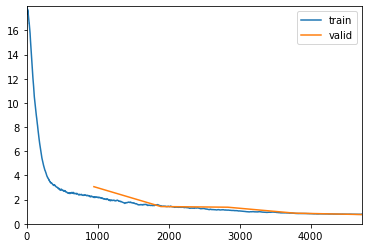

In [23]:
learn = Learner(data,
                VPPEncoder(fin = len(features), nhead = 5, nhid = 128, nlayers = 6, seq_len=80, use_decoder = True),
                opt_func= QHAdam,
                loss_func = vppAutoLoss, #vppAutoSmoothL1Loss 
                metrics=[vppMetric, vppGenMetric], 
                cbs=[ShowGraphCallback()]).to_fp16() 

learn.fit_one_cycle(EPOCHS, 2e-3) 

Th CV score after 100 epochs is 0.227013 for vppMetric and 0.255794 for vppGenMetric. Leaderboard scores for this singele model training in the entire train-dataset were 0.2090 private LB and 0.2091 public LB.

# References
- Competition Home Page: https://www.kaggle.com/c/ventilator-pressure-prediction
- Area features: https://www.kaggle.com/cdeotte/ensemble-folds-with-median-0-153
- Memory reduction: https://www.kaggle.com/konradb/tabnet-end-to-end-starter
- Dataloader from numpy: https://www.kaggle.com/junkoda/pytorch-lstm-with-tensorflow-like-initialization
- Dropout discussion: https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/276719
- Transformer model: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
- LSTM model: https://www.kaggle.com/theoviel/deep-learning-starter-simple-lstm
- LSTM parameter initialization: https://www.kaggle.com/junkoda/pytorch-lstm-with-tensorflow-like-initialization
- SmoothL1Loss discussion: https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/277690